In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import lambertw
from numpy import exp, log
%matplotlib inline

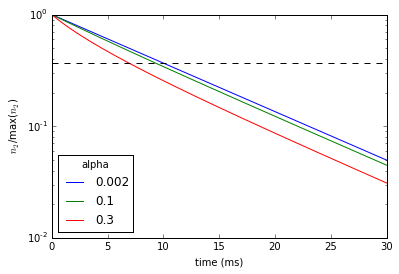

In [60]:
tau = 10
t = np.linspace(0,30,1000)
c=0
plt.figure()

for alpha in [0.002, 0.1, 0.3]:
    n = -lambertw(-alpha*exp(c-t/tau)).real/alpha
    plt.semilogy(t,n/max(n), label=alpha)

plt.axhline(1/np.e, ls='--', color='k')
plt.legend(loc='best', title='alpha')
plt.ylabel('$n_2$/max($n_2$)')
plt.xlabel('time (ms)')
# plt.savefig('decaysVsAlpha.png', dpi=300)

# Sympy Solution

In [ ]:
from sympy import *
init_printing()

In [ ]:
n, n1, n2, sigma_12, sigma_21, tau, t = symbols('n, n1, n2, sigma_12, sigma_21, tau, t')

In [ ]:
Eq(W_p*(N_1-N_3) - N_3/t_3, 0)